In [5]:
import pandas as pd
import numpy as np
import os
import glob
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
DATA_FOLDER = 'Electricity consumption Netherlands/Electricity'
all_files = glob.glob(os.path.join(DATA_FOLDER, "*.csv"))

city_yearly_data = []

for file_path in all_files:
    # Extract city and year from filename
    filename = os.path.basename(file_path)
    parts = filename.replace('.csv', '').split('_')
    city = parts[0]
    year = int(parts[2])

    try:
        # Read the csv. We don't care about column order here.
        df_temp = pd.read_csv(file_path)
        print(city)
        # Aggregate to city level for that year
        # Summing consumption and connections, averaging percentages
        aggregated = {
            'city': city,
            'year': year,
            'total_annual_consume': df_temp['annual_consume'].sum(),
            'total_num_connections': df_temp['num_connections'].sum(),
            #'avg_smartmeter_perc': df_temp['smartmeter_perc'].mean()
            # Add other aggregations you find useful
        }
        city_yearly_data.append(aggregated)

    except Exception as e:
        print(f"Could not process file {filename}: {e}")


stedin
stedin
stedin
stedin
liander
enexis
westland-infra
enexis
endinet
rendo
liander
coteq
liander
rendo
endinet
enexis
enexis
rendo
endinet
liander
liander
coteq
enduris
enexis
endinet
rendo
rendo
enexis
enduris
coteq
liander
liander
enexis
rendo
endinet
westland-infra
westland-infra
rendo
endinet
enexis
liander
coteq
enduris
rendo
westland-infra
westland-infra
enexis
rendo
enduris
coteq
liander
coteq
enduris
westland-infra
westland-infra
liander
enduris
coteq
liander
westland-infra
westland-infra
liander
coteq
enexis
westland-infra
enexis
enduris
stedin
stedin
stedin
stedin
stedin
stedin
stedin
stedin


In [7]:
master_df = pd.DataFrame(city_yearly_data)
master_df = master_df.sort_values(by=['city', 'year']).reset_index(drop=True)

print("--- Initial Consolidated Data ---")
print(master_df.head())

# --- Step 2: Feature Engineering ---
# We will do this per city
df_featured = master_df.copy()

# Lag features
df_featured['consumption_lag_1'] = df_featured.groupby('city')['total_annual_consume'].shift(1)
df_featured['consumption_lag_2'] = df_featured.groupby('city')['total_annual_consume'].shift(2)

# Rolling window features
df_featured['rolling_mean_2y'] = df_featured.groupby('city')['total_annual_consume'].shift(1).rolling(2).mean()

# Drop rows with NaN values created by lag/rolling features
df_featured = df_featured.dropna().reset_index(drop=True)

# Use city name as a categorical feature
df_featured['city'] = df_featured['city'].astype('category')

print("\n--- Data After Feature Engineering ---")
print(df_featured.head())

--- Initial Consolidated Data ---
    city  year  total_annual_consume  total_num_connections
0  coteq  2013            10239701.0                52582.0
1  coteq  2014            10239701.0                52582.0
2  coteq  2015            10239701.0                52582.0
3  coteq  2016            10239701.0                52582.0
4  coteq  2017            10239701.0                52582.0

--- Data After Feature Engineering ---
    city  year  total_annual_consume  total_num_connections  \
0  coteq  2015            10239701.0                52582.0   
1  coteq  2016            10239701.0                52582.0   
2  coteq  2017            10239701.0                52582.0   
3  coteq  2018            10239701.0                52582.0   
4  coteq  2019            10179609.0                54924.0   

   consumption_lag_1  consumption_lag_2  rolling_mean_2y  
0         10239701.0         10239701.0       10239701.0  
1         10239701.0         10239701.0       10239701.0  
2         

/var/folders/dt/738vp7mj3zggd8nnvk0jnxtc0000gn/T/ipykernel_74841/1071089465.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(y/1e9)}B' for y in current_values])


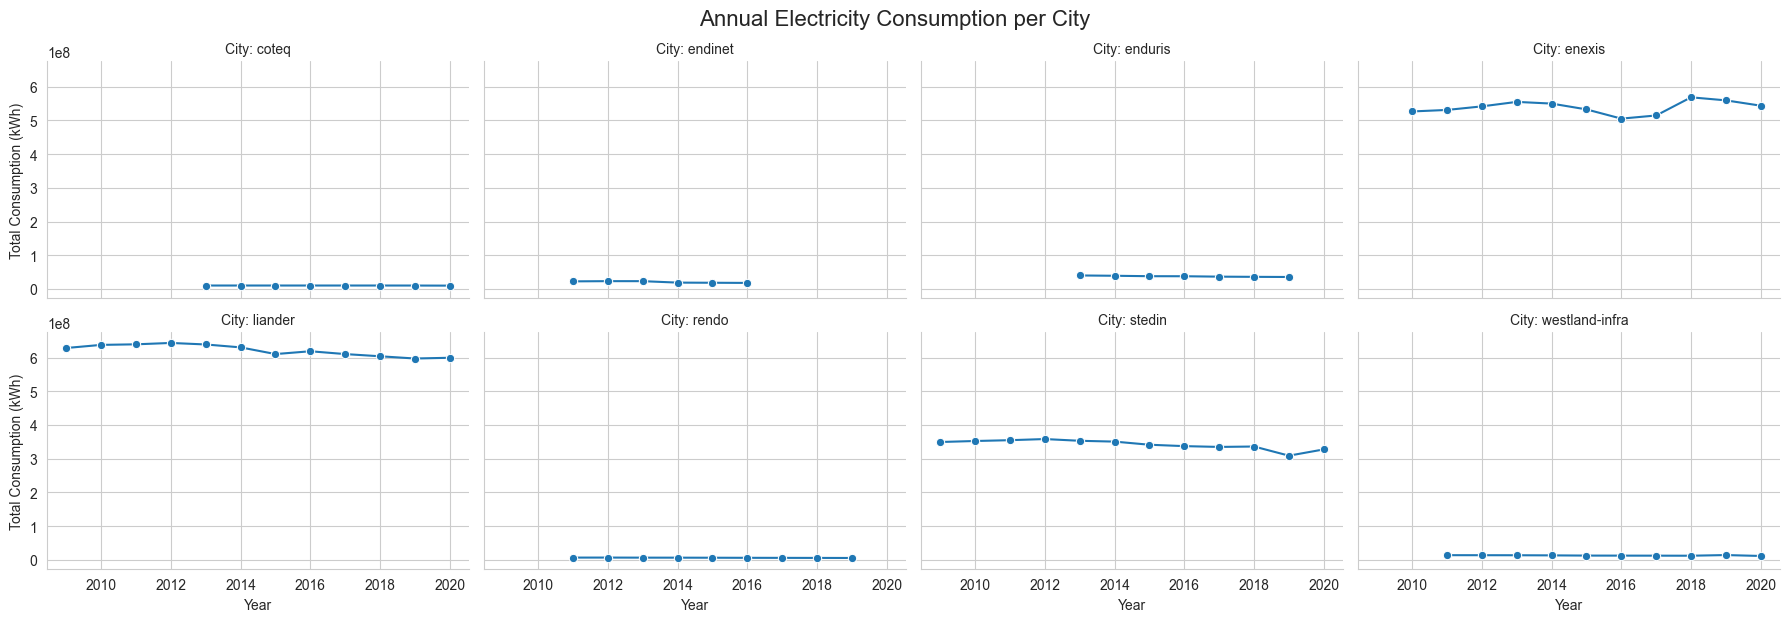

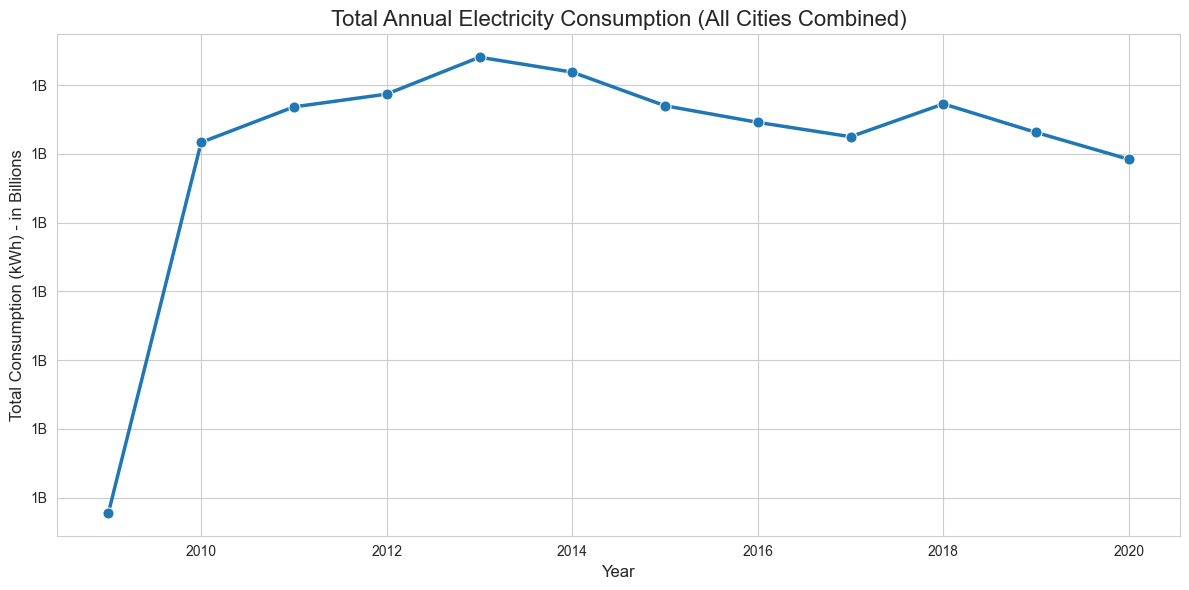


--- Total Consumption by Year ---
    year  total_annual_consume
0   2009          9.778573e+08
1   2010          1.516647e+09
2   2011          1.568266e+09
3   2012          1.586852e+09
4   2013          1.640487e+09
5   2014          1.618779e+09
6   2015          1.569896e+09
7   2016          1.545747e+09
8   2017          1.524901e+09
9   2018          1.572586e+09
10  2019          1.531071e+09
11  2020          1.492001e+09


In [8]:

# Set a nice style for the plots
sns.set_style("whitegrid")

# Use seaborn's relplot to create a facet grid.
# This is the most powerful and flexible method.
g = sns.relplot(
    data=master_df,
    x='year',
    y='total_annual_consume',
    col='city',          # Create a new column of plots for each city
    kind='line',         # Specify the plot type as a line plot
    col_wrap=4,          # Wrap the subplots into the next row after 4 columns
    height=3,            # Height of each subplot
    aspect=1.5,          # Aspect ratio of each subplot
    marker='o'           # Add markers to the points
)

# Add a main title for the entire figure
g.fig.suptitle('Annual Electricity Consumption per City', fontsize=16, y=1.03)

# Improve individual subplot labels if needed
g.set_titles("City: {col_name}")
g.set_axis_labels("Year", "Total Consumption (kWh)")

sns.set_style("whitegrid")

# =========================================================
# PLOT FOR TOTAL CUMULATIVE CONSUMPTION ACROSS ALL CITIES
# =========================================================

# First, create a new dataframe for total consumption
# We group the master_df by year and sum up the consumption
total_consumption_df = master_df.groupby('year')['total_annual_consume'].sum().reset_index()

# Now, plot this new dataframe
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=total_consumption_df,
    x='year',
    y='total_annual_consume',
    marker='o',
    linewidth=2.5, # Make the line a bit thicker for emphasis
    markersize=8    # Make the markers bigger
)

# Add titles and labels
plt.title('Total Annual Electricity Consumption (All Cities Combined)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Consumption (kWh) - in Billions', fontsize=12) # Assuming large numbers

# Optional: Improve formatting for large y-axis numbers
# This formats the y-axis to be more readable (e.g., 1.5e10 becomes 15B)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(y/1e9)}B' for y in current_values])

plt.tight_layout()
plt.show()

# Print the data you're plotting for verification
print("\n--- Total Consumption by Year ---")
print(total_consumption_df)
# Show the plot
plt.show()

In [10]:
# Create a new DataFrame for features
data_for_model = total_consumption_df.copy()

# 1. Lag Features
data_for_model['lag_1'] = data_for_model['total_annual_consume'].shift(1)
data_for_model['lag_2'] = data_for_model['total_annual_consume'].shift(2)

# 2. Rolling Window Feature (Mean of last 2 years of consumption)
# We use .shift(1) to prevent data leakage (only use past data)
data_for_model['rolling_mean_2y'] = data_for_model['total_annual_consume'].shift(1).rolling(window=2).mean()

# 3. Growth Rate Feature
data_for_model['diff_1'] = data_for_model['total_annual_consume'].shift(1).diff(1)


# After creating these features, the first few rows will have missing values (NaN)
# We must drop them as a model cannot train on them.
data_for_model = data_for_model.dropna().reset_index(drop=True)


print("\n--- Data After Feature Engineering ---")
print(data_for_model)


--- Data After Feature Engineering ---
   year  total_annual_consume         lag_1         lag_2  rolling_mean_2y  \
0  2011          1.568266e+09  1.516647e+09  9.778573e+08     1.247252e+09   
1  2012          1.586852e+09  1.568266e+09  1.516647e+09     1.542456e+09   
2  2013          1.640487e+09  1.586852e+09  1.568266e+09     1.577559e+09   
3  2014          1.618779e+09  1.640487e+09  1.586852e+09     1.613670e+09   
4  2015          1.569896e+09  1.618779e+09  1.640487e+09     1.629633e+09   
5  2016          1.545747e+09  1.569896e+09  1.618779e+09     1.594337e+09   
6  2017          1.524901e+09  1.545747e+09  1.569896e+09     1.557821e+09   
7  2018          1.572586e+09  1.524901e+09  1.545747e+09     1.535324e+09   
8  2019          1.531071e+09  1.572586e+09  1.524901e+09     1.548743e+09   
9  2020          1.492001e+09  1.531071e+09  1.572586e+09     1.551828e+09   

         diff_1  
0  5.387895e+08  
1  5.161897e+07  
2  1.858609e+07  
3  5.363557e+07  
4 -2.170830

In [11]:
# Define our features and target
target = 'total_annual_consume'
features = [
    'year',
    'lag_1',
    'lag_2',
    'rolling_mean_2y',
    'diff_1'
]

# Split the data
train_df = data_for_model.iloc[:-1] # All rows except the last one
test_df = data_for_model.iloc[-1:]  # The very last row

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

last_known_year = X_train['year'].max()
prediction_year = X_test['year'].iloc[0]

print(f"\nTraining on data up to year {last_known_year}.")
print(f"Testing on data for year {prediction_year}.")
print(f"Number of training samples: {len(X_train)}")


Training on data up to year 2019.
Testing on data for year 2020.
Number of training samples: 9


In [12]:
lgb_model = lgb.LGBMRegressor(
    objective='regression_l1', # MAE
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 0
[LightGBM] [Info] Start training from score 1569895552.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

LGBMRegressor(objective='regression_l1', random_state=42)


--- Model Evaluation ---
Prediction for year 2020: 1,569,895,552
Actual value for year 2020:   1,492,001,040
Absolute Error: 77,894,512
Percentage Error: 5.22%


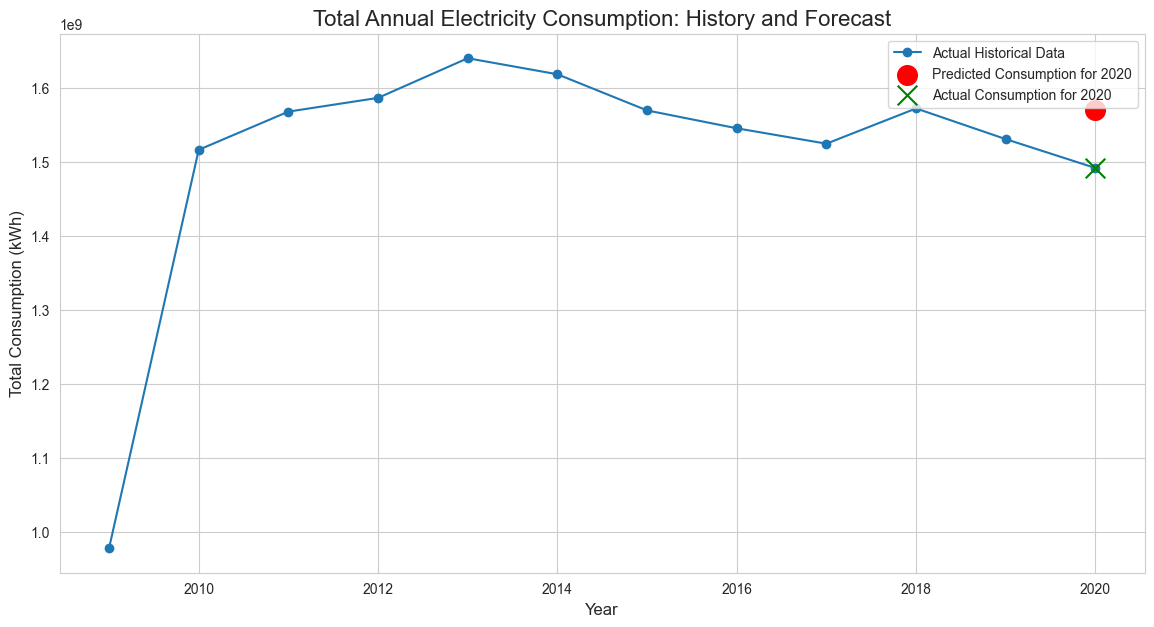

In [13]:
# Predict on the single test row
prediction = lgb_model.predict(X_test)

# Get the single predicted value and the single actual value
predicted_value = prediction[0]
actual_value = y_test.iloc[0]

# Calculate evaluation metrics
mae = abs(predicted_value - actual_value)
percentage_error = (mae / actual_value) * 100

print("\n--- Model Evaluation ---")
print(f"Prediction for year {prediction_year}: {predicted_value:,.0f}")
print(f"Actual value for year {prediction_year}:   {actual_value:,.0f}")
print(f"Absolute Error: {mae:,.0f}")
print(f"Percentage Error: {percentage_error:.2f}%")


# --- Visualize the prediction against historical data ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))

# Plot all historical data
plt.plot(total_consumption_df['year'], total_consumption_df['total_annual_consume'], label='Actual Historical Data', marker='o')

# Plot the predicted point
plt.scatter([prediction_year], [predicted_value], color='red', s=200, zorder=5, label=f'Predicted Consumption for {prediction_year}')
# Plot the actual test point for comparison
plt.scatter([prediction_year], [actual_value], color='green', s=200, marker='x', zorder=5, label=f'Actual Consumption for {prediction_year}')

plt.title('Total Annual Electricity Consumption: History and Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Consumption (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()